# Анализ поведения пользователей мобильного приложения

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 

**Цель исследования:**
Изучение воронки продаж и интерпретация результатов проведенного А/В теста.

**Ход исследования:**
1) Подготовка данных
2) Изучение данных
3) Изучение воронки событий
4) Изучение результатов проведенного А/В теста

**Описание данных:**

Каждая запись в логе — это действие пользователя, или событие. 
1) EventName — название события;
2) DeviceIDHash — уникальный идентификатор пользователя;
3) EventTimestamp — время события;
4) ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


## 1. Подготовка данных

In [1]:
import pandas as pd  # импортируем библиотеки
import numpy as np
import seaborn as sns
import math as mth
import matplotlib.pyplot as plt
from scipy import stats as st
import plotly.express as px

In [2]:
data=pd.read_csv('/Users/alena/Desktop/datasets/logs_exp.csv', sep='\t')
#открываем файл

In [3]:
data.info() # выведем на экран информацию о датасете для ознакомления

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
data.head(10) #выведем на экран первые 10 строк датафрейма для ознакомления со структурой

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [5]:
#изменим названия столбцов для удобства работы
data = data.rename(columns={'EventName':'event_name','DeviceIDHash':'device_id_hash',
                            'EventTimestamp':'event_timestamp', 'ExpId':'exp_id'})

In [6]:
data.isna().sum() # сколько пропущено значений в каждом столбце

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

In [7]:
data.duplicated().sum() #проверка на явные дубликаты

413

In [8]:
data = data.drop_duplicates() #удалим дубликаты

In [9]:
# для дальнейшего анализа создадим столбцы с датой и временем

data['event_date_time'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['event_date'] = data['event_date_time'].dt.date

In [10]:
data.head() # выведем начало таблицы на экран для проверки произведенных изменений

,event_name,device_id_hash,event_timestamp,exp_id,event_date_time,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


На этапе предобработки выявлено, что данные считываются корректно. Удалены явные дубликаты, изменены для удобства анализа названия столбцов и добавлены новые с датой и временем. Пропусков в данных не обнаружено.

## 2. Изучение данных

In [11]:
# Изучим количество событий и пользователей, сколько событий приходится в среднем на одного пользователя
pd.set_option("display.float_format", "{:.2f}".format) 


print('Всего событий в логе: {} \n'
    'Всего пользователей в логе: {} \n'
      'В среднем событий на пользователя: {}'.format(data['event_name'].count(), 
                                              data['device_id_hash'].nunique(),
                                        round(data['event_name'].count()/data['device_id_hash'].nunique(),2)))


Всего событий в логе: 243713 
Всего пользователей в логе: 7551 
В среднем событий на пользователя: 32.28


In [12]:
print('Минимальная дата: {} \n'
      'Максимальная дата: {} '.format(data['event_date_time'].min(),
                                     data['event_date_time'].max()))

Минимальная дата: 2019-07-25 04:43:36 
Максимальная дата: 2019-08-07 21:15:17 


В датафрейме представлены данные за период с 25 июля по 7 августа 2019 года.

Для того, чтобы проверить, одинаково ли полные данные за весь период, построим гистограмму:

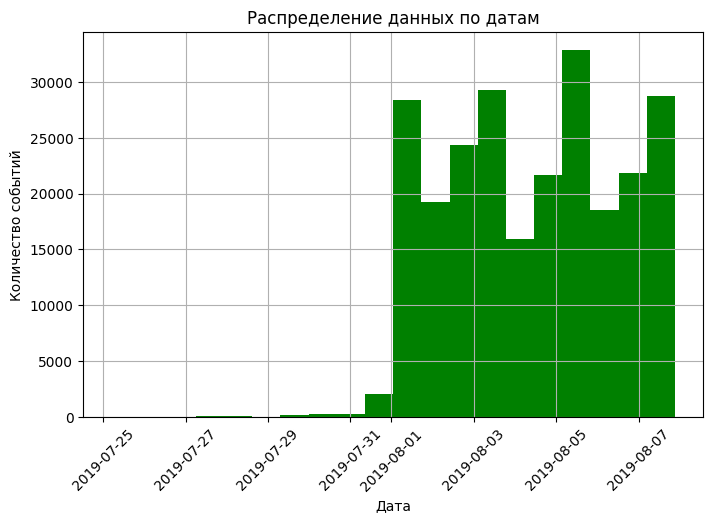

In [13]:
data.hist(column='event_date_time', figsize=(8,5), bins=20, color='green')
plt.title('Распределение данных по датам')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

На гистограмме видно, что данных за период до 31 июля представлено гораздо меньше, чем за август. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Для анализа отбросим часть и возьмем данные с 1 августа 2019 года.

In [14]:
log = data.loc[(data['event_date_time'] >= "2019-08-01")] #отфильтруем нужные данные

In [15]:
# посчитаем потери при фильтрации данных
print('Потери при фильтрации по событиям: {:.2%}'
      .format((data['event_name'].count()-log['event_name'].count())/data['event_name'].count()))
print('Потери при фильтрации по уникальным пользователям: {:.2%}'
      .format((data['device_id_hash'].nunique()-log['device_id_hash'].nunique())/data['device_id_hash'].nunique()))

Потери при фильтрации по событиям: 1.16%
Потери при фильтрации по уникальным пользователям: 0.23%


Потери при фильтрации данных незначительные, можно продолжать анализ.

Иследуем, есть ли в данных пользователи из всех трех экспериментальных групп и нет ли пользователей, оказавшихся в двух группах одновременно:

In [16]:
log.pivot_table(index='exp_id', aggfunc={'device_id_hash':['count', 'nunique']})

device_id_hash        
                count nunique
exp_id                       
246             79302    2484
247             77022    2513
248             84563    2537

In [18]:
# Проверим пользователей, которые могли участвовать в двух или нескольких группах одновременно:
log.groupby('device_id_hash').agg({'exp_id':'nunique'}).query('exp_id > 1') 


,exp_id
device_id_hash,


На этапе изучения данных принято решение исследовать данных за период с 1 по 7 августа 2019, так как они наиболее полно представлены в датасете. Потери при фильтрации данных незначительные - 1.16%. Пользователей, вошедших одновременно в несколько экспериментальных групп нет. Данные готовы к дальнейшему анализу.

## 3. Изучение воронки событий

Изучим, какие события есть в логах и как часто они встречаются:

In [19]:
log.pivot_table(index='event_name', aggfunc={'event_date':'count'}).sort_values(by='event_date', ascending=False)

,event_date
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


Чаще всего происходит событие - показ главного экрана, реже всего пользователи проходят обучение. Теперь посчитаем, сколько пользователей совершали каждое из этих событий и посчитаем долю пользователей, которые хоть раз совершали событие:

In [20]:
pivot_event = log.pivot_table(index='event_name', 
                aggfunc={'device_id_hash':'nunique', }).sort_values(by='device_id_hash', ascending=False)
pivot_event['percent_per_all_users'] = pivot_event['device_id_hash']/log['device_id_hash'].nunique()*100
display(pivot_event)

,device_id_hash,percent_per_all_users
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


По предыдущей таблице можно примерно наметить последовательность событий для пользователей приложения: от показа главной страницы (событие происходит у 98% пользователей) до успешной оплаты заказа (у 47%). Исключение  - прохождение обучения по приложению (tutorial) - его проходит только 11% от всех пользователей, неизвестно на каком этапе пользования приложением. Для дальнейшего подсчета будем использовать данные без события tutorial.

In [24]:
# исключим tutorial
event_funnel = pivot_event.query('event_name !="Tutorial"').reset_index()
# посчитаем процент пользователей, которые доходят до каждого этапа по сравнению с предыдущим
event_funnel['percent_per_previous'] = event_funnel['device_id_hash']/event_funnel['device_id_hash'].shift(1)*100
event_funnel = event_funnel.sort_values(by='device_id_hash', ascending=False)
event_funnel['percent_per_previous'] = event_funnel['percent_per_previous'].fillna(100.00)

display(event_funnel)


,event_name,device_id_hash,percent_per_all_users,percent_per_previous
0,MainScreenAppear,7419,98.47,100.00
1,OffersScreenAppear,4593,60.96,61.91
2,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78


In [25]:
print('Доходит до оплаты от первого этапа {:.2%} пользователей'.format(
    event_funnel.loc[3]['device_id_hash']/event_funnel.loc[0]['device_id_hash'])
     )

Доходит до оплаты от первого этапа 47.70% пользователей


Из таблицы выше видно, что больше всего пользователей приложение теряет еще на этапе главного экрана - на следующий этап (экран предложения) переходят только 62% пользователей. На остальных этапах воронки конверсия лучше - 81% переходит в корзину и 94% перешедших в корзину успешно оплачивают свои покупки. Всего до успешной оплаты от первого события доходит 47% пользователей приложения.

## 4. Изучение результатов эксперимента

In [26]:
# Узнаем, сколько уникальных пользователей в каждой экспериментальной группе
logs = log.query('event_name != "Tutorial"')
total_users =(
    log.groupby(by='exp_id').agg({'device_id_hash':'nunique'})
.rename(columns={'device_id_hash':'trials'})
)
display(total_users)

,trials
exp_id,
246,2484
247,2513
248,2537


Группы 246 и 247 - контрольные группы для проведения А/А эксперимента, чтобы проверить корректность всех механизмов и расчётов. Необходимо проверить, находят ли статистические критерии разницу между выборками 246 и 247. Для проверки разницы между этими группами используем метод z-test.

In [27]:
# создадим сводную таблицу для проверки гипотез
events_pivot = (
    logs.pivot_table(index='exp_id', columns='event_name', values= 'device_id_hash', aggfunc='nunique')
 
)
events_pivot['trials'] = total_users['trials'] # добавим общее количество пользователей каждой группы
events_names = logs['event_name'].unique() #создадим переменную с уникальными названиями событий

events_pivot

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,trials
exp_id,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537


In [28]:
events_names

array(['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear',
       'PaymentScreenSuccessful'], dtype=object)

In [29]:
# напишем функцию для проверки гипотез
def p_value_check (group1, group2, event, alpha):
    trials_1 = events_pivot.loc[group1]['trials']
    trials_2 = events_pivot.loc[group2]['trials']
    successes_1 = events_pivot.loc[group1][event]
    successes_2 = events_pivot.loc[group2][event]
    trials = np.array([trials_1, trials_2])
    successes = np.array([successes_1, successes_2])
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Событие', event, 'p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными') 


Сформулируем гипотезы. Нулевая: различий в числе пользователей, совершивших события между группами 246 и 247 нет. Альтернативная: различия в числе пользователей между группами есть.

Для множественных проверок применим поправку Бонферрони: значение альфа 0.05 разделим на 16 (количество событий, умноженное на количество проверок):

In [30]:
alpha = 0.05/16
alpha

0.003125

In [31]:
# с помощью цикла проверим гипотезы для групп 246 и 247
for i in range(0, len(events_names)):
    p_value_check(246, 247, events_names[i], alpha )

Событие MainScreenAppear p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Событие OffersScreenAppear p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Событие CartScreenAppear p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Событие PaymentScreenSuccessful p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


Вывод: в результате проверки отсутствуют основания считать группы разными, значит, что А/А тест проведен верно и можно приступать к анализу проведенного А/В теста. Для этого необходимо проверить, находят ли статистические критерии разницу между выборками группы с измененным шрифтом с каждой из контрольных групп по отдельности по каждому событию, а также с объединенной группой.

Сформулируем гипотезы. Нулевая: различий в числе пользователей, совершивших события между группами 246 и 248 нет. Альтернативная: различия в числе пользователей между группами есть.


In [32]:
for i in range(0, len(events_names)):
    p_value_check(246, 248, events_names[i], alpha )

Событие MainScreenAppear p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Событие OffersScreenAppear p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Событие CartScreenAppear p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Событие PaymentScreenSuccessful p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


Вывод: в результате проверки отсутствуют основания считать группы разными, значит, что изменение шрифта не влияет на увеличение конверсии. Для подтверждения продолжим проверку.

Сформулируем гипотезы. Нулевая: различий в числе пользователей, совершивших события между группами 247 и 248 нет. Альтернативная: различия в числе пользователей между группами есть.

In [33]:
for i in range(0, len(events_names)):
    p_value_check(247, 248, events_names[i], alpha )

Событие MainScreenAppear p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Событие OffersScreenAppear p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Событие CartScreenAppear p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Событие PaymentScreenSuccessful p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


Вывод: в результате проверки отсутствуют основания считать группы разными, значит, что изменение шрифта не влияет на увеличение конверсии. Для подтверждения продолжим проверку.

Сформулируем гипотезы. Нулевая: различий в числе пользователей, совершивших события между объединенной группой 246 и 247 и группой 248 нет. Альтернативная: различия в числе пользователей между группами есть.

In [34]:
#доюавим в таблицу объединенную группу 246 и 247 
events_pivot.loc['aa'] =  (
        [events_pivot.loc[246]['CartScreenAppear']+events_pivot.loc[247]['CartScreenAppear'],
       events_pivot.loc[246]['MainScreenAppear']+events_pivot.loc[247]['MainScreenAppear'],
    events_pivot.loc[246]['OffersScreenAppear']+events_pivot.loc[247]['OffersScreenAppear'],
       events_pivot.loc[246]['PaymentScreenSuccessful']+events_pivot.loc[247]['PaymentScreenSuccessful'],
        events_pivot.loc[246]['trials']+events_pivot.loc[247]['trials']]
)
events_pivot

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,trials
exp_id,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537
aa,2504,4926,3062,2358,4997


In [35]:
for i in range(0, len(events_names)):
    p_value_check('aa', 248, events_names[i], alpha )

Событие MainScreenAppear p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Событие OffersScreenAppear p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Событие CartScreenAppear p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Событие PaymentScreenSuccessful p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


Вывод: в результате проверки отсутствуют основания считать группы разными, значит, что изменение шрифта не влияет на увеличение конверсии.
Данное утверждение в результате проверки всех гипотез говорит о том, что результаты проведенного А/В теста показали нецелесообразность введения тестируемых изменений, так как они не влияют на увеличение конверсии.

## 5. Вывод по результатам исследования

На этапе изучения данных принято решение исследовать данных за период с 1 по 7 августа 2019, так как они наиболее полно представлены в датасете. Потери при фильтрации данных незначительные - 1.16% событий, 0.23% уникальных пользователей. Пользователей, вошедших одновременно в несколько экспериментальных групп нет. 

По имеющимся данным можно наметить последовательность событий для пользователей приложения: от показа главной страницы (событие происходит у 98% пользователей) до успешной оплаты заказа (у 47%). Исключение  - прохождение обучения по приложению (tutorial) - его проходит только 11% от всех пользователей, неизвестно на каком этапе пользования приложением.

Больше всего пользователей приложение теряет еще на этапе главного экрана - на следующий этап (экран предложения) переходят только 62% пользователей. На остальных этапах воронки конверсия лучше - 81% переходит в корзину и 94% перешедших в корзину успешно оплачивают свои покупки. Всего до успешной оплаты от первого события доходит 47% пользователей приложения.

При анализе результатов А/А теста выявлено, что группы однородны и могут быть использованы для проведения А/В тестирования.

В результате проверки  статистической значимости различий отсутствуют основания считать группы разными, значит, что изменение шрифта не влияет на увеличение конверсии. Данное утверждение в результате проверки всех гипотез говорит о том, что результаты проведенного А/В теста показали нецелесообразность введения тестируемых изменений, так как они не влияют на увеличение конверсии.